<a href="https://www.kaggle.com/code/peremartramanonellas/improve-tensorflow-performance-with-graph-mode?scriptVersionId=124612302" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
from IPython.core.display import HTML
HTML("""
<style>
font-family: monospace;
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    horizontal-align: middle;
}
h1 {
    text-align: center;
    background-color: AliceBlue;
    padding: 10px;
    margin: 0;
    font-family: monospace;
    color:DimGray;
    border-radius: 10px
}

h2 {
    text-align: center;
    background-color: HoneyDew;
    padding: 10px;
    margin: 0;
    font-family: monospace;
    color:DimGray;
    border-radius: 10px
}

h3 {
    text-align: center;
    background-color: MintCream;
    padding: 10px;
    margin: 0;
    font-family: monospace;
    color:DimGray;
    border-radius: 10px
}


body, p {
    font-family: monospace;
    font-size: 15px;
    color: charcoal;
}
div {
    font-size: 14px;
    margin: 0;

}

h4 {
    padding: 0px;
    margin: 0;
    font-family: monospace;
    color: purple;
}
</style>
""")



# Graph Mode vs Eager Mode. Improve drastically and easily the performance of your TensorFlow Notebooks. 
The code in graph mode is much more efficient and can give us a huge performance boost.

At the beginning of this notebook, there is a brief introduction to graph mode. Initially, we will see their differences and a few examples of how the code looks in graph mode.  As well as how we can easily go from eager mode to graph mode.

After the brief introduction, we will move on to solving a classification problem with the human_vs_horses dataset. Running the solution in both eager and graphical modes, so we can easily compare performance.

*The notebook is ready to work also with the cats_vs_dogs Dataset. But the memory limitations we encountered in Kaggle prevent us from running it with such a large Dataset. In case you want to test with other Datasets or even with a more complex model, you can download the notebook. This is configured to run without issues in a local environment.*

## brief introduction to graph mode & differences with eager mode
To simplify, the eager mode is more intuitive, easier to code and debug, and is the natural way to develop. The graph mode is better for performance. 

Let's look at some code, in eager and graph mode. 

#### Eager Mode
def func(x):

    if x > 0:
    
        x = x + 1
        
    return x

#### Graph Mode
def func(x):

    def if_true():
    
        return x + 1
        
    def if_false():
    
        return x
        
    x = tf.cond(tf.greater(x, 0), if_true, if_false)
    
    return x
    
As you can see, the code in graph mode is much more difficult to write and understand than the code in eager mode. But there is great news. We do not need to write the code in graph mode. Autograph does it for us.

Another great news is that the two types of code can coexist. So, we can use graph mode only for those functions that are expensive in time. Two points where they are usually used in the execution of custom models, and in the transformation of data.

### Trying the autograph. 
We are going to use the autograph to convert some functions from eager to graph. 


In [2]:
import tensorflow as tf
import time

In [3]:
@tf.function
def func(X):
    if x > 0: 
        x = x + 1
    return x

We have decorated our function with ***@tf.function***. We don't see the graph code, but when we call it, the function will run in graph mode. 

Now let's see the generated code.

In [4]:
print (tf.autograph.to_code(func.python_function))

def tf__func(X):
    with ag__.FunctionScope('func', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()

        def get_state():
            return (x,)

        def set_state(vars_):
            nonlocal x
            (x,) = vars_

        def if_body():
            nonlocal x
            x = (ag__.ld(x) + 1)

        def else_body():
            nonlocal x
            pass
        x = ag__.Undefined('x')
        ag__.if_stmt((ag__.ld(x) > 0), if_body, else_body, get_state, set_state, ('x',), 1)
        try:
            do_return = True
            retval_ = ag__.ld(x)
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)



Ok! That's the code autogenerated in graph mode. As you can see is even more complex that the one that i writed as a sample. But the structure is similar.  The functions used are defined at the beginning, and we execute the code inside a function calling the functions witted previously. 

You may ask,why can't I decorate every function in the notebook?  Easy, not all works fine in graph mode, there are some tricks that we must know. 



**If we need to use Tensor variables, they can't be declared inside the function.**

In [5]:
#This function will fail as it does not support declaring tf variables in the body. 
#if you want to execute and test it, remove the comments. 

#@tf.function
#def f(x):
#    v = tf.Variable(1.0)
#    return v.assign_add(x)

#print(f(5))

In [6]:
#For it to work, we just have to remove the variable and declare it outside the function
v = tf.Variable(1.0)
@tf.function
def f(x):
    return v.assign_add(x)

print(f(5))

tf.Tensor(6.0, shape=(), dtype=float32)


Another thing to consider is how the print() function works. **In graphical mode, the print function, will only execute once,** no matter how many times we call it in a loop. 

We must replace it with ***tf.print()***.

In [7]:
@tf.function
def print_test(): 
    tf.print("with tf.print")
    print("with print")
    

for i in range(5):
    print_test()

with print
with tf.print
with tf.print
with tf.print
with tf.print
with tf.print


Something similar happens with ***ASSERT***, which we must replace with the corresponding ***tf.debugging.assert_***

# Compare eager vs graph using the Cats vs Dogs dataset or Human vs Horses. 
We are going to use a custom model to solve an image classification problem using the horse_or_humans dataset, which we can find in TensorFlow Datasets.

I've decided to use a Dataset from the TensorFlow Datasets database to make it easier to download the notebook and run tests on our own computer, with other datasets like cats_vs_dogs, or even with more complex models like the ones we found in TensorFlow HUB.

In [8]:
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import time

## Import & data
We retrieved the data from a TensorFlow dataset instead of Kaggle to make it easier to run the notebook in other environments and make it easier to test.

In [9]:
#Choose the Dataset you want to use. 
#In Kaggle I do not recommend cats_vs_dogs 
#because we can reach the limit of memory consumption.

#setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")
#TS_2_DOWNLOAD = 'cats_vs_dogs'

TS_2_DOWNLOAD = 'horses_or_humans'

splits, info_cd = tfds.load(TS_2_DOWNLOAD, 
                         as_supervised=True, 
                         with_info=True, 
                         split=['train[:70%]', 'train[70%:90%]', 'train[90%:]'], 
                         data_dir='./data')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1027 [00:00<?, ? examples/s]

Shuffling horses_or_humans-train.tfrecord...:   0%|          | 0/1027 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/256 [00:00<?, ? examples/s]

Shuffling horses_or_humans-test.tfrecord...:   0%|          | 0/256 [00:00<?, ? examples/s]

Dataset horses_or_humans downloaded and prepared to ./data/horses_or_humans/3.0.0. Subsequent calls will reuse this data.


In [10]:
num_examples_cd = info_cd.splits['train'].num_examples
num_classes_cd = info_cd.features['label'].num_classes

(train_examples, validation_examples, test_examples) = splits
num_examples = num_examples_cd
num_classes = num_classes_cd

## Eager vs Graph

In [11]:
BATCH_SIZE = 32
IMAGE_SIZE = 224

Now I'm going to create two functions to deal with the images. Nothing will be done other than adapt the size and normalize the image.

It is an operation that can be heavy, depending on the size of the images and the Dataset. Besides that, it is a function that can be passed effortlessly to Graph mode.

The code is the same in both functions. The only difference is the decoration in the map_fn_graph. 

In [12]:
#Treat the image in eager mode. 
def map_fn_eager(img, label):
    # resize the image
    img = tf.image.resize(img, size=[IMAGE_SIZE, IMAGE_SIZE])
    # normalize the image
    img /= 255.0
    return img, label

In [13]:
# #Treat the image in graph mode. 
@tf.function
def map_fn_graph(img, label):
    # resize the image
    img = tf.image.resize(img, size=[IMAGE_SIZE, IMAGE_SIZE])
    # normalize the image
    img /= 255.0
    return img, label

In [14]:
# Prepare train dataset by using preprocessing with map_fn_eager or graph, shuffling and batching
def prepare_dataset(train_examples, validation_examples, test_examples, num_examples, map_fn, batch_size):
    train_ds = train_examples.map(map_fn).shuffle(buffer_size = num_examples).batch(batch_size)
    valid_ds = validation_examples.map(map_fn).batch(batch_size)
    test_ds = test_examples.map(map_fn).batch(batch_size)
    
    return train_ds, valid_ds, test_ds

In [15]:
start_time = time.time()
train_ds_eager, valid_ds_eager, test_ds_eager = prepare_dataset(train_examples, 
                                                                validation_examples, 
                                                                test_examples, 
                                                                num_examples, 
                                                                map_fn_eager, BATCH_SIZE)
end_time = time.time()
print ("Time spend:",  end_time - start_time)

Time spend: 0.062294721603393555


In [16]:
start_time = time.time()
train_ds_graph, valid_ds_graph, test_ds_graph = prepare_dataset(train_examples, 
                                                                validation_examples, 
                                                                test_examples, 
                                                                num_examples, 
                                                                map_fn_graph, BATCH_SIZE)
end_time = time.time()
print ("Time spend:",  end_time - start_time)

Time spend: 0.05785417556762695


With this data set and using the Kaggle GPUs, the elapsed time is minimal. Less than one second. Even so, an improvement of 30% is appreciated over time. 

With a larger dataset, or with quality images like the ones we could find in medical analysis problems, the time saved could be significant.

# Executing the model

If you want you can use some models from TensorFlow HUB, just uncomment the lines commented, and comment the line with the sequential model. 

With bigger models, it is easier to see the performance differences, but in Kaggle we have some limitations, and we can run out of memory. 

But if you decide to download the notebook, and execute in your computer, I think it would be a good idea to test the performance with several models, to get a better view of the improvement obtained.

In [17]:
#MODULE_HANDLE = 'https://tfhub.dev/tensorflow/resnet_50/feature_vector/1'
#MODULE_HANDLE = 'https://tfhub.dev/google/imagenet/resnet_v2_152/classification/5'
#model = tf.keras.Sequential([
#    hub.KerasLayer(MODULE_HANDLE, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
#    tf.keras.layers.Dense(num_classes, activation='softmax')
#])

model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(16, (4,4), activation="relu", input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
            tf.keras.layers.MaxPooling2D(2,2),
            tf.keras.layers.Dropout(0.2),   
            tf.keras.layers.Conv2D(32, (4,4), activation="relu"),
            tf.keras.layers.MaxPooling2D(2,2),  
            tf.keras.layers.Dropout(0.2),  
            tf.keras.layers.Conv2D(64, (4,4), activation="relu"),
            tf.keras.layers.MaxPooling2D(2,2),  
            tf.keras.layers.Dropout(0.5), 
            tf.keras.layers.Flatten(), 
            tf.keras.layers.Dense(512, activation="relu"), 
            tf.keras.layers.Dense(2, activation="softmax")])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 221, 221, 16)      784       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 110, 110, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 107, 107, 32)      8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 53, 53, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 64)        3

In [18]:
optimizer = tf.keras.optimizers.Adam()
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
train_loss = tf.keras.losses.SparseCategoricalCrossentropy()
val_loss = tf.keras.losses.SparseCategoricalCrossentropy()

In [19]:
# Custom training step. This function is executed in each step each epoch. 
def train_one_step(model, optimizer, x, y, train_loss, train_accuracy):
    with tf.GradientTape() as tape:
        # Run the model on input x to get predictions
        predictions = model(x)
        # Compute the training loss using `train_loss`, passing in the true y and the predicted y
        loss = train_loss(y, predictions)

    # Using the tape and loss, compute the gradients on model variables using tape.gradient
    grads = tape.gradient(loss, model.trainable_variables)
    
    # Zip the gradients and model variables, and then apply the result on the optimizer
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Call the train accuracy object on ground truth and predictions
    train_accuracy(y, predictions)
    return loss

Now I am going to define two functions, one to execute in eager mode and the other in graph mode.

Both functions will call ***train_on_step***. You can see that it isn't decorated, but it doesn't need to be, since TensorFlow not only transforms the decorated functions, but also all the ones called from it.

That is, ***train_one_step*** will run in eager mode when called from ***train_eager***, and in graph mode when called from ***train_graph***.

In [20]:

def train_eager(model, optimizer, epochs, train_ds, train_loss, train_accuracy, valid_ds, val_loss, val_accuracy):
    step = 0
    loss = 0.0
    for epoch in range(epochs):
        for x, y in train_ds:
            # training step number increments at each iteration
            step += 1

            # Run one training step by passing appropriate model parameters
            # required by the function and finally get the loss to report the results
            loss = train_one_step(model, optimizer, x, y, train_loss, train_accuracy)

            # Use tf.print to report your results.
            # Print the training step number, loss and accuracy
            print('Step', step, 
                   ': train loss', loss, 
                   '; train accuracy', train_accuracy.result())

        for x, y in valid_ds:
            # Call the model on the batches of inputs x and get the predictions
            y_pred = model(x)
            loss = val_loss(y, y_pred)
            val_accuracy(y, y_pred)
        # Print the validation loss and accuracy
        
        tf.print('val loss', loss, '; val accuracy', val_accuracy.result())

The ***train_graph*** function has a small modification. 

I have replaced the call to the ***print*** function with a call to ***tf.print***.  
Since as we have seen at the beginning of the notebook, print is only executed once, and we need it to print the values at each step, and at each epoch.

In [21]:
@tf.function
def train_graph(model, optimizer, epochs, train_ds, train_loss, train_accuracy, valid_ds, val_loss, val_accuracy):
    step = 0
    loss = 0.0
    for epoch in range(epochs):
        for x, y in train_ds:
            # training step number increments at each iteration
            step += 1

            # Run one training step by passing appropriate model parameters
            # required by the function and finally get the loss to report the results
            loss = train_one_step(model, optimizer, x, y, train_loss, train_accuracy)

            # Use tf.print to report your results.
            # Print the training step number, loss and accuracy
            tf.print('Step', step, 
                   ': train loss', loss, 
                   '; train accuracy', train_accuracy.result())

        for x, y in valid_ds:
            # Call the model on the batches of inputs x and get the predictions
            y_pred = model(x)
            loss = val_loss(y, y_pred)
            val_accuracy(y, y_pred)

        # Print the validation loss and accuracy
        tf.print('val loss', loss, '; val accuracy', val_accuracy.result())

In [22]:
#Solving the model in eager mode, and printing the time elapsed. 
st = time.time()
train_eager(model, optimizer, 6, train_ds_eager, 
            train_loss, train_accuracy, valid_ds_eager, 
            val_loss, val_accuracy)
et = time.time()
print(et - st)

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

Step 1 : train loss tf.Tensor(0.7318816, shape=(), dtype=float32) ; train accuracy tf.Tensor(0.375, shape=(), dtype=float32)
Step 2 : train loss tf.Tensor(8.879311, shape=(), dtype=float32) ; train accuracy tf.Tensor(0.515625, shape=(), dtype=float32)
Step 3 : train loss tf.Tensor(2.0693283, shape=(), dtype=float32) ; train accuracy tf.Tensor(0.5208333, shape=(), dtype=float32)
Step 4 : train loss tf.Tensor(4.102291, shape=(), dtype=float32) ; train accuracy tf.Tensor(0.4921875, shape=(), dtype=float32)
Step 5 : train loss tf.Tensor(1.8404226, shape=(), dtype=float32) ; train accuracy tf.Tensor(0.49375, shape=(), dtype=float32)
Step 6 : train loss tf.Tensor(0.7700146, shape=(), dtype=float32) ; train accuracy tf.Tensor(0.5104167, shape=(), dtype=float32)
Step 7 : train loss tf.Tensor(0.6617205, shape=(), dtype=float32) ; train accuracy tf.Tensor(0.52678573, shape=(), dtype=float32)
Step 8 : train loss tf.Tensor(0.72194177, shape=(), dtype=float32) ; train accuracy tf.Tensor(0.52734375,

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

val loss 0.229061604 ; val accuracy 0.89268291
Step 24 : train loss tf.Tensor(0.34080732, shape=(), dtype=float32) ; train accuracy tf.Tensor(0.689747, shape=(), dtype=float32)
Step 25 : train loss tf.Tensor(0.17720252, shape=(), dtype=float32) ; train accuracy tf.Tensor(0.6998723, shape=(), dtype=float32)
Step 26 : train loss tf.Tensor(0.2716396, shape=(), dtype=float32) ; train accuracy tf.Tensor(0.70552146, shape=(), dtype=float32)
Step 27 : train loss tf.Tensor(0.2520623, shape=(), dtype=float32) ; train accuracy tf.Tensor(0.7154664, shape=(), dtype=float32)
Step 28 : train loss tf.Tensor(0.2938758, shape=(), dtype=float32) ; train accuracy tf.Tensor(0.7224118, shape=(), dtype=float32)
Step 29 : train loss tf.Tensor(0.16875121, shape=(), dtype=float32) ; train accuracy tf.Tensor(0.72996706, shape=(), dtype=float32)
Step 30 : train loss tf.Tensor(0.35883933, shape=(), dtype=float32) ; train accuracy tf.Tensor(0.73276776, shape=(), dtype=float32)
Step 31 : train loss tf.Tensor(0.1105

In [23]:
#Solving the model in graph mode, and printing the time elapsed. 
st = time.time()
train_graph(model, optimizer, 6, train_ds_graph, 
            train_loss, train_accuracy, valid_ds_graph, 
            val_loss, val_accuracy)
et = time.time()
print(et - st)

Step 1 : train loss 0.0113857221 ; train accuracy 0.920386553
Step 2 : train loss 0.00245724199 ; train accuracy 0.920968473
Step 3 : train loss 0.00123249646 ; train accuracy 0.921541929
Step 4 : train loss 0.000821825757 ; train accuracy 0.92210716
Step 5 : train loss 0.0082052676 ; train accuracy 0.922664285
Step 6 : train loss 0.00161436095 ; train accuracy 0.923213482
Step 7 : train loss 0.000934211712 ; train accuracy 0.92375493
Step 8 : train loss 0.000865034759 ; train accuracy 0.924288869
Step 9 : train loss 0.000767617952 ; train accuracy 0.924815297
Step 10 : train loss 0.000860867789 ; train accuracy 0.925334513
Step 11 : train loss 0.000501754519 ; train accuracy 0.925846577
Step 12 : train loss 0.0135465879 ; train accuracy 0.926351666
Step 13 : train loss 0.003770323 ; train accuracy 0.926849902
Step 14 : train loss 0.00104648573 ; train accuracy 0.927341461
Step 15 : train loss 0.000132593064 ; train accuracy 0.927826464
Step 16 : train loss 0.00304113864 ; train accura

The execution time is quite variable between different executions, but at the time of this writing, **the model in eager mode took 21 seconds, while in graph mode it took only 10. That is, it took only half of the time**. 

It should be noted **that not only are there differences in performance, but an improvement in the accuracy and loss of the model is also achieved**. Not huge, but we can't ignore it.

With eager mode, we obtain an accuracy of 0.974 while with Graph mode, the accuracy obtained is 0.987. **It would be necessary to study if this difference is maintained between executions, in different machines, and with different models.**

These numbers have been obtained by training for only two epochs and using Kaggle's P100 GPUs, with the horse vs human dataset.

If you download the notebook you can try it with any of the two TensorFlow hub models that have been prepared, I recommend resnet_50, and with the cats vs dogs dataset, which is much larger.

You will see that the times are very different, it is even possible that just by lowering the notebook, without changing anything, both the final time and the percentage of performance improvement change, which can be even better.

On my laptop, **the performance improvement is about 70%**. This may be due to a parallelization improvement or the type of GPU, no idea. 


# Check the Model 

In [24]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

In [25]:
class_names = ['cats', 'dogs']
class_names = ['horse', 'human']
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    
    # green-colored annotations will mark correct predictions. red otherwise.
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    
    # print the true label first
    print(true_label)
  
    # show the image and overlay the prediction
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

In [26]:
test_imgs = []
test_labels = []

predictions = []
for images, labels in test_ds_eager:
    preds = model(images)
    preds = preds.numpy()
    predictions.extend(preds)

    test_imgs.extend(images.numpy())
    test_labels.extend(labels.numpy())

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

0


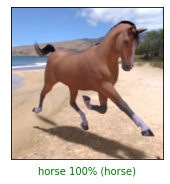

In [27]:
# Visualize the outputs 
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(100, predictions, test_labels, test_imgs)
plt.show()

# Conclusions & Fork & Play
We have seen how with little effort we can achieve a significant improvement in our notebooks.

It's as simple as decorating the function we want to speed up with tf.function, and complying with some development rules.

It is true that many examples are missing from the notebook and the code will need more modifications. But the improvements achieved are worth it.

So dedicating a little more effort to development to obtain such a significant gain in training and execution time is something that surely pays off.

## Experiments to do
If you have a powerful machine, try changing the Dataset or the Model, so you can see if the gain percentage increases or decreases as the process becomes more complicated.

A good place to try this technique is on NLP models. Treating text to make it ready to use in an NLP model is usually a huge resource hog, surely Autograph can be used to improve this performance.

I plan to try it later, but if you do before I do, I'd love for you to tell me how it worked. I wait for you in the comments!

# More Notebooks in the TensorFlow Serie.
I'm working in a serie of notebooks with some interesting techniques in Tensorflow: *Tensorflow beyond the basics*.

How to create a Siamese Network to compare images. https://www.kaggle.com/code/peremartramanonellas/how-to-create-a-siamese-network-to-compare-images

Multiple outputs with Keras Functional API. 
https://www.kaggle.com/code/peremartramanonellas/guide-multiple-outputs-with-keras-functional-api/edit/run/109206893

In my medium profile you can find the articles where each of the notebooks is explained.
https://medium.com/@peremartra

#### **Please, if you liked the notebook, consider upvoting it. It really encourages me a lot to write more notebooks like that.**